# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import numpy as np
import pandas as pd
import random
#pour supprimer les warnings sur retouche des copies de dataframe
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl
from datetime import datetime
import itertools
import graphviz as gv
import seaborn as sns

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut
from iads import kmoyennes as km
from iads import hierarchie as he

## Chargement des données (base MovieLens + enrichissements)

In [3]:
# Chargement des données MovieLens
#links = pd.read_csv('data/links.csv', encoding='utf8')
#movies = pd.read_csv('data/movies.csv', encoding='utf8')
#ratings = pd.read_csv('data/ratings.csv', encoding='utf8')
# = pd.read_csv('data/tags.csv', encoding='utf8')
#genome_scores = pd.read_csv('data/genome-scores.csv', encoding='utf8')
# = pd.read_csv('data/genome-tags.csv', encoding='utf8')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [39]:
# Chargement des données complémentaires
acteurs = pkl.load(open('data/act_v2.pkl', "rb"))
films = pkl.load(open('data/film_v2.pkl', "rb"))
crews = pkl.load(open('data/crew_v2.pkl', "rb"))

Comme problème de classification supervisée, nous avons choisi comme sujet la prédiction de l'ordre. Ainsi, nous devons assembler tous les dictionnaires contenus dans la liste créée à partir du fichier pickle `act_v2.pkl` et supprimer les colonnes à priori non pertinantes : ici la colonne `profile_path`. De même pour les `credit_id` ; un `credit_id` n'associant qu'un acteur à un seul film, il n'apparaît donc qu'une fois dans la base et ne pourra donc pas influer sur l'ordre dans d'autres films.  
En ce qui concerne `name`, puisqu'il y a plus d'`id` que d'acteurs différents, `id` n'est donc pas l'identifiant d'un acteur et il faut donc garder la variable catégorielle `name` pour la classification. De même pour le personnage, car un personnage peut apparaître dans différents films et donc influencer l'ordre.

In [42]:
data_acteurs = pd.DataFrame(list(itertools.chain.from_iterable(acteurs)))
print(len(set(data_acteurs['id'])))
print(len(set(data_acteurs['name'])))
print(len(set(data_acteurs['credit_id'])))
print(len(set(data_acteurs['character'])))
data_acteurs = data_acteurs.drop("profile_path", axis=1)
data_acteurs = data_acteurs.drop("credit_id", axis=1)
print(data_acteurs.shape[0])
data_acteurs = data_acteurs[:int(data_acteurs.shape[0]/400)]
print(data_acteurs.shape[0])
ordermax = np.max(data_acteurs['order'])
data_acteurs.head()

165302
162910
422860
249771
422860
1057


,cast_id,character,gender,id,name,order
0,14,Woody (voice),2,31,Tom Hanks,0
1,15,Buzz Lightyear (voice),2,12898,Tim Allen,1
2,16,Mr. Potato Head (voice),2,7167,Don Rickles,2
3,17,Slinky Dog (voice),2,12899,Jim Varney,3
4,18,Rex (voice),2,12900,Wallace Shawn,4


In [43]:
s = list(set(data_acteurs['name']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
data_acteurs['name'] = data_acteurs['name'].apply(lambda e : dico[e])
data_acteurs['name'] = data_acteurs['name'].astype(int)

s = list(set(data_acteurs['character']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
data_acteurs['character'] = data_acteurs['character'].apply(lambda e : dico[e])
data_acteurs['character'] = data_acteurs['character'].astype(int)
data_acteurs.head()

,cast_id,character,gender,id,name,order
0,14,351,2,31,280,0
1,15,525,2,12898,671,1
2,16,897,2,7167,663,2
3,17,432,2,12899,924,3
4,18,97,2,12900,935,4


In [44]:
lset = ls.LabeledSet(data_acteurs.shape[1]-1)
#lset.addExample(data_acteurs.iloc[ : , : -1 ].values, data_acteurs.iloc[ : , -1: ].values)
#lset.x = data_acteurs[['cast_id', 'character', 'credit_id', 'gender', 'id', 'name']].values
lset.x = data_acteurs[['cast_id', 'character', 'gender', 'id', 'name']].values
lset.y = data_acteurs['order'].values
#.apply(lambda e : 1 if e == 3 else -1)
lset.nb_examples = lset.y.shape[0]
dact1, dact2 = ut.split(lset, 0.5)

L'ordre ayant un ensemble de valeurs possibles dont le cardinal est bien supérieur à 2, il faut donc appliquer une méthode de classification multi-classes. Nous avons choisi le modèle "un contre tous".

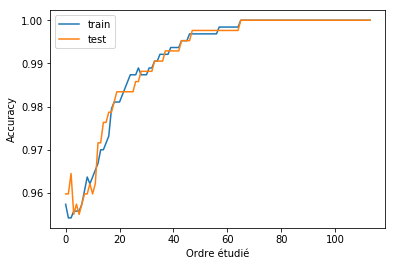

In [48]:


k = list(range(0,ordermax+50,1))
restrain = []
restest = []

# 1 contre tous
for i in range(ordermax+50):
    lset = ls.LabeledSet(data_acteurs.shape[1]-1)
    percept = cl.ClassifierPerceptron(lset.getInputDimension(), 0.3)
    lset.x = data_acteurs[['cast_id', 'character', 'gender', 'id', 'name']].values
    lset.y = data_acteurs['order'].apply(lambda e : 1 if e == i else -1)
    lset.nb_examples = lset.y.shape[0]
    dact1, dact2 = ut.split(lset, 0.6)
    res1 = percept.accuracy(dact1)
    res2 = percept.accuracy(dact2)

    for _ in range(50):
        percept.train(dact1)
        tmp = percept.accuracy(dact1)
        res1 = tmp if tmp > res1 else res1
        tmp = percept.accuracy(dact2)
        res2 = tmp if tmp > res2 else res2
        #restrain.append(percept.accuracy(dact1))
        #restest.append(percept.accuracy(dact2))
    restrain.append(res1)
    restest.append(res2)
plt.plot(k, restrain, label="train")
plt.plot(k, restest, label="test")
plt.xlabel("Ordre étudié")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

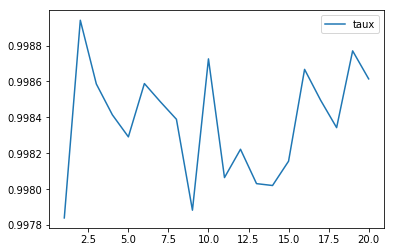

In [13]:
ltrain = []

k = range(1,21,1)
for i in k:
    foret = cl.ClassifierBaggingTreeOOB(i, 0.3,0.99, True)
    t = foret.train(dact1)
    ltrain.append(foret.taux())

plt.plot(k,ltrain, label="taux")
plt.legend(loc="best")
plt.show()

Le perceptron multi-classes et le BaggingTree Out of Bag montrent des résultats similaire, à savoir que la prédiction est efficace, l'accuracy étant au-dessus des 95%.

In [52]:
data_films = pd.DataFrame(films)
data_films.head(80)

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg,"[16, 35, 10751]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",22.773,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,Toy Story,False,7.9,9550
1,False,/7k4zEgUZbzMHawDaMc9yIkmY1qR.jpg,"[12, 14, 10751]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,2.947,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg,1995-12-15,Jumanji,False,7.1,5594
2,False,/1ENbkuIYK2taNGGKNMs2hw6SaJb.jpg,"[35, 10749]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,6.076,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995-12-22,Grumpier Old Men,False,6.5,140
3,False,/u0hQzp4xfag3ZhsKKBBdgyIVvCl.jpg,"[35, 18, 10749]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",2.917,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg,1995-12-22,Waiting to Exhale,False,6.1,55
4,False,/cZs50rEk4T13qWedon0uCnbYQzW.jpg,[35],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,6.817,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,Father of the Bride Part II,False,6.1,288
5,False,/jMzVSwQp1lLVq9fnQQ4yOjr1YZ2.jpg,"[28, 80, 18, 53]",949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",13.666,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,1995-12-15,Heat,False,7.8,3002
6,False,/hSy5yZG18ogNQn1tHSlxSqV24cf.jpg,"[35, 10749]",11860,en,Sabrina,An ugly duckling having undergone a remarkable...,6.177,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,1995-12-15,Sabrina,False,6.1,260
7,False,/43r8WYBhOrj0SLSTuShynuWj6Z.jpg,"[28, 12, 18, 10751]",45325,en,Tom and Huck,"A mischievous young boy, Tom Sawyer, witnesses...",3.567,/sGO5Qa55p7wTu7FJcX4H4xIVKvS.jpg,1995-12-22,Tom and Huck,False,5.3,73
8,False,/y6A4PUAD61r15CgtuuQhWxLh6Vx.jpg,"[28, 12, 18, 53]",9091,en,Sudden Death,When a man's daughter is suddenly taken during...,5.890,/ridz4IucWay8dBP5t68rGYykCvi.jpg,1995-10-27,Sudden Death,False,5.7,279
9,False,/dA9I0Vd9OZzRQ2GyGcsFXdKGMz3.jpg,"[12, 28, 53]",710,en,GoldenEye,James Bond must unmask the mysterious head of ...,16.629,/5c0ovjT41KnYIHYuF4AWsTe3sKh.jpg,1995-11-16,GoldenEye,False,6.8,1853


Pour un premier clustering non supervisé, nous nous basons sur la table films, pour grouper les films par leur popularité et en prenant en compte leurs genres.

Fusion de  0  et  96 pour une distance de  2.89056668052168
Fusion de  23  et  47 pour une distance de  2.8321240469997897
Fusion de  37  et  100 pour une distance de  2.829555097981862
Fusion de  53  et  101 pour une distance de  2.8293724155791664
Fusion de  22  et  33 pour une distance de  2.828894339374461
Fusion de  5  et  103 pour une distance de  2.828835796857432
Fusion de  36  et  46 pour une distance de  2.722052264806719
Fusion de  7  et  106 pour une distance de  2.713081876286751
Fusion de  105  et  107 pour une distance de  2.7123487084848725
Fusion de  69  et  108 pour une distance de  2.707745052032732
Fusion de  8  et  102 pour une distance de  2.7012934503053145
Fusion de  109  et  110 pour une distance de  2.697907087962608
Fusion de  104  et  111 pour une distance de  2.6943618689457836
Fusion de  91  et  112 pour une distance de  2.69321403656298
Fusion de  90  et  113 pour une distance de  2.693032270442794
Fusion de  93  et  114 pour une distance de  2.6905059776

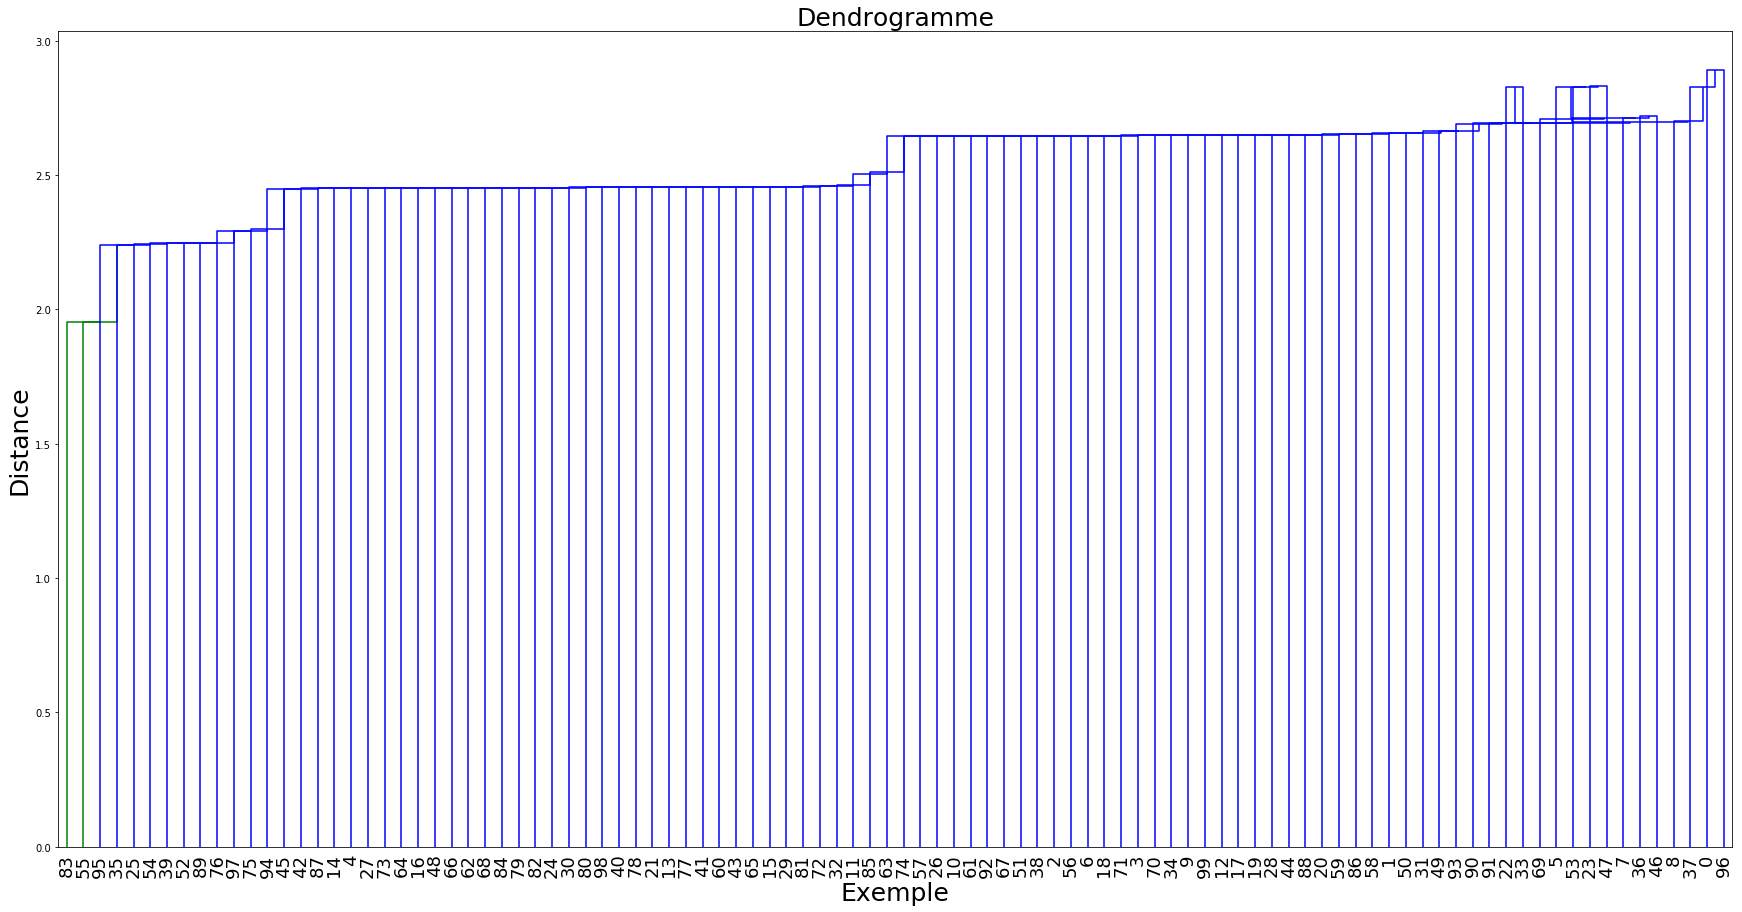

array([[  0.        ,  96.        ,   2.89056668,   2.        ],
       [ 23.        ,  47.        ,   2.83212405,   2.        ],
       [ 37.        , 100.        ,   2.8295551 ,   2.        ],
       [ 53.        , 101.        ,   2.82937242,   2.        ],
       [ 22.        ,  33.        ,   2.82889434,   2.        ],
       [  5.        , 103.        ,   2.8288358 ,   2.        ],
       [ 36.        ,  46.        ,   2.72205226,   2.        ],
       [  7.        , 106.        ,   2.71308188,   2.        ],
       [105.        , 107.        ,   2.71234871,   2.        ],
       [ 69.        , 108.        ,   2.70774505,   2.        ],
       [  8.        , 102.        ,   2.70129345,   2.        ],
       [109.        , 110.        ,   2.69790709,   2.        ],
       [104.        , 111.        ,   2.69436187,   2.        ],
       [ 91.        , 112.        ,   2.69321404,   2.        ],
       [ 90.        , 113.        ,   2.69303227,   2.        ],
       [ 93.        , 114

In [25]:
s = pd.Series(data_films['genre_ids'])
d= pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
data= pd.concat([d,data_films[['popularity','vote_count']]], axis=1)
normfilm= km.normalisation(data)
normfilm = normfilm.fillna(normfilm.mean())
he.clustering_hierarchique_max(normfilm[:100].values, "euclidienne")

En tant que catégorisation non supervisée, nous avons utilisé la base crew, dont nous voulons supprimer les colonnes `profile_path` et `credit_id` qui ne sont pas utiles au processus. Ensuite, il faut traité les éléments textuels restant ; ici, les `name` et les `job` sont trop nombreux pour être traiter en dummy coding, il le seront donc de manière discrète.

In [20]:
data_crews = pd.DataFrame(list(itertools.chain.from_iterable(crews)))
data_crews.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/gasNitCwepbqNcYBmDHpsCgZH0I.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/cCJDIvQatfefZtB9cI49S2L3erC.jpg
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


In [18]:
data_crews = data_crews.drop(['profile_path'], axis=1)
data_crews = data_crews.drop(['credit_id'], axis=1)
s = list(set(data_crews['job']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
data_crews['job'] = data_crews['job'].apply(lambda e : dico[e])
data_crews['job'] = data_crews['job'].astype(int)

s = list(set(data_crews['name']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
data_crews['name'] = data_crews['name'].apply(lambda e : dico[e])
data_crews['name'] = data_crews['name'].astype(int)
print(list(set(data_crews['department'])))
dc = pd.concat([pd.get_dummies(data_crews['department']),data_crews.drop(['department'], axis=1)],axis=1)
dc

['Visual Effects', 'Directing', 'Sound', 'Crew', 'Editing', 'Writing', 'Lighting', 'Production', 'Actors', 'Costume & Make-Up', 'Camera', 'Art']


,Actors,Art,Camera,Costume & Make-Up,Crew,Directing,Editing,Lighting,Production,Sound,Visual Effects,Writing,gender,id,job,name
0,0,0,0,0,0,1,0,0,0,0,0,0,2,7879,184,137319
1,0,0,0,0,0,0,0,0,0,0,0,1,2,12891,272,14569
2,0,0,0,0,0,0,0,0,0,0,0,1,2,7,272,78418
3,0,0,0,0,0,0,0,0,0,0,0,1,2,12892,272,47630
4,0,0,0,0,0,0,0,0,0,0,0,1,0,12893,272,43959
5,0,0,0,0,0,0,0,0,1,0,0,0,1,12894,749,94665
6,0,0,0,0,0,0,0,0,1,0,0,0,2,12895,295,45216
7,0,0,0,0,0,0,0,0,1,0,0,0,2,12896,749,113736
8,0,0,0,0,0,0,0,0,1,0,0,0,2,12897,295,83801
9,0,0,0,0,0,0,1,0,0,0,0,0,2,8,179,81672


In [19]:
idcrew = he.initialise(dc[:100]['id'])
print(idcrew)
d= km.normalisation(dc.iloc[: , 12:])
d = pd.concat([dc.iloc[:, :12], d], axis=1)

{0: [7879], 1: [12891], 2: [7], 3: [12892], 4: [12893], 5: [12894], 6: [12895], 7: [12896], 8: [12897], 9: [8], 10: [7883], 11: [1168870], 12: [1552883], 13: [1453514], 14: [1414182], 15: [7885], 16: [1429549], 17: [7949], 18: [7879], 19: [12890], 20: [7911], 21: [1629419], 22: [7961], 23: [12905], 24: [1748707], 25: [4949], 26: [1372885], 27: [1739962], 28: [1748513], 29: [1458006], 30: [1748557], 31: [7], 32: [12890], 33: [2216], 34: [12909], 35: [953331], 36: [7893], 37: [8025], 38: [78009], 39: [1748682], 40: [1454030], 41: [1748683], 42: [1748684], 43: [8029], 44: [1426773], 45: [8035], 46: [1748688], 47: [587314], 48: [7918], 49: [1748689], 50: [7892], 51: [555795], 52: [7882], 53: [8017], 54: [1184140], 55: [1509559], 56: [1748691], 57: [8050], 58: [8010], 59: [8044], 60: [1454034], 61: [7887], 62: [1406878], 63: [1748698], 64: [1748699], 65: [1748701], 66: [1748703], 67: [12912], 68: [7899], 69: [12915], 70: [1748705], 71: [7918], 72: [7], 73: [12915], 74: [1176752], 75: [10880

Fusion de  57  et  59 pour une distance de  0.0038592517686069916
Fusion de  43  et  52 pour une distance de  0.008032580763138689
Fusion de  29  et  79 pour une distance de  0.02411356205357895
Fusion de  64  et  66 pour une distance de  0.027929491943894796
Fusion de  17  et  45 pour une distance de  0.02941210239548205
Fusion de  39  et  41 pour une distance de  0.033023970090445096
Fusion de  53  et  100 pour une distance de  0.035447688949266164
Fusion de  48  et  50 pour une distance de  0.047212393742916005
Fusion de  25  et  90 pour une distance de  0.04921067547216131
Fusion de  65  et  103 pour une distance de  0.0500200307137611
Fusion de  42  et  46 pour une distance de  0.05244708556114711
Fusion de  69  et  104 pour une distance de  0.054449828501997415
Fusion de  87  et  88 pour une distance de  0.06383788475816717
Fusion de  73  et  111 pour une distance de  0.07517783239861038
Fusion de  49  et  105 pour une distance de  0.07615009686967597
Fusion de  78  et  80 pour u

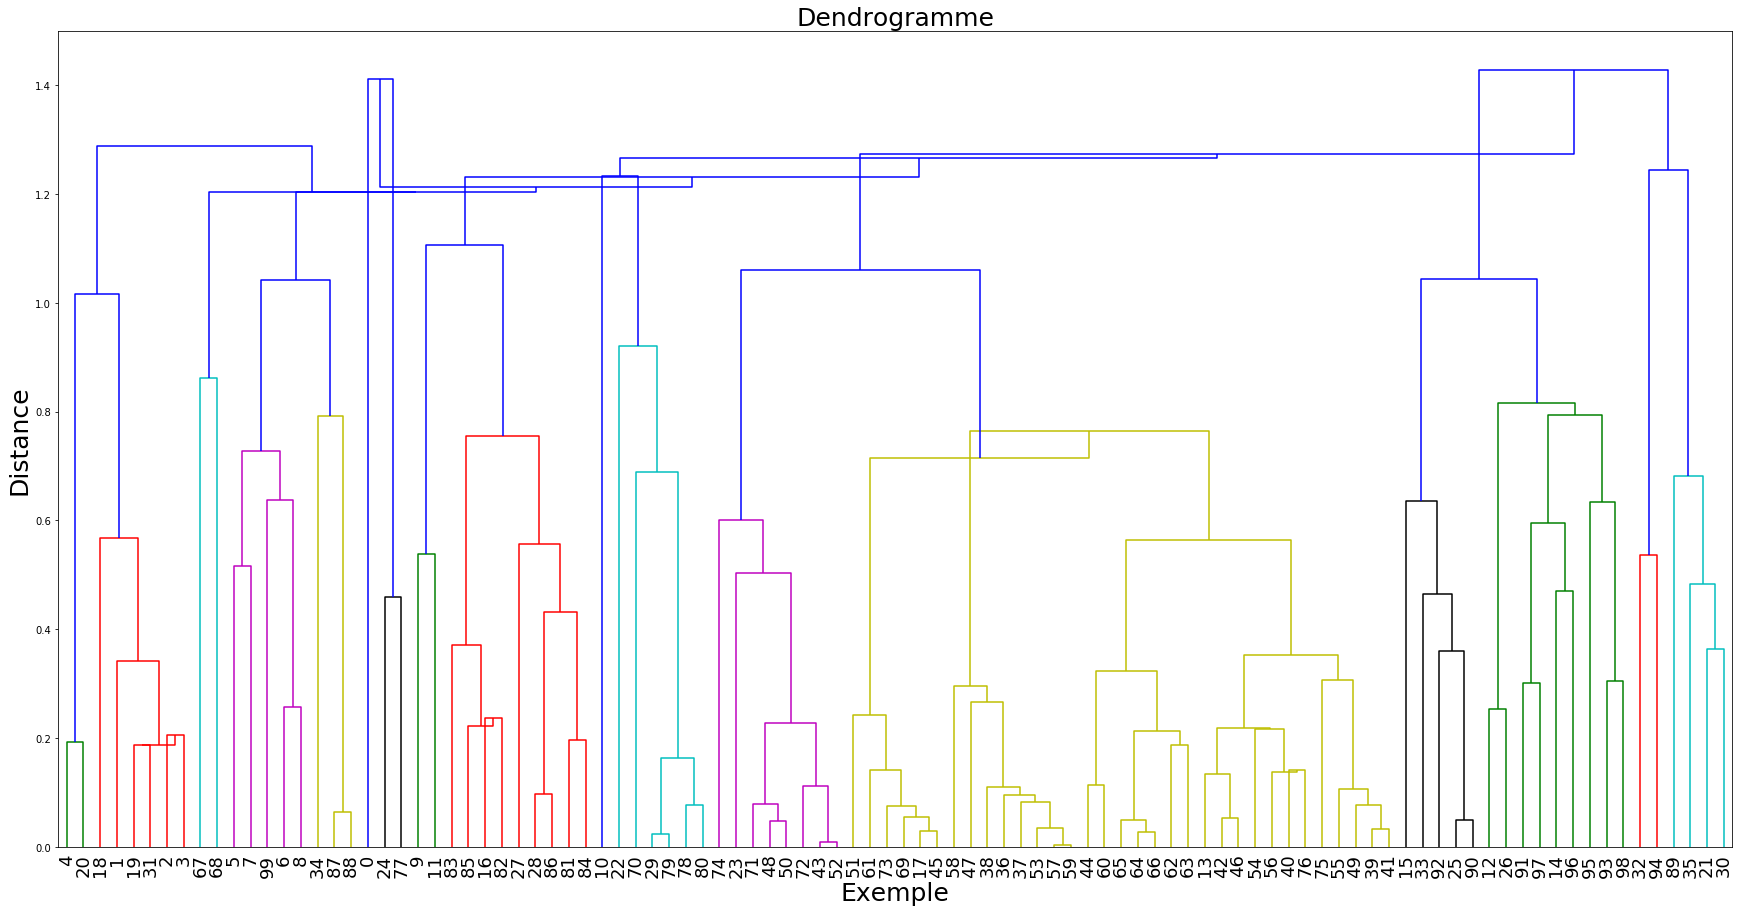

array([[5.70000000e+01, 5.90000000e+01, 3.85925177e-03, 2.00000000e+00],
       [4.30000000e+01, 5.20000000e+01, 8.03258076e-03, 2.00000000e+00],
       [2.90000000e+01, 7.90000000e+01, 2.41135621e-02, 2.00000000e+00],
       [6.40000000e+01, 6.60000000e+01, 2.79294919e-02, 2.00000000e+00],
       [1.70000000e+01, 4.50000000e+01, 2.94121024e-02, 2.00000000e+00],
       [3.90000000e+01, 4.10000000e+01, 3.30239701e-02, 2.00000000e+00],
       [5.30000000e+01, 1.00000000e+02, 3.54476889e-02, 2.00000000e+00],
       [4.80000000e+01, 5.00000000e+01, 4.72123937e-02, 2.00000000e+00],
       [2.50000000e+01, 9.00000000e+01, 4.92106755e-02, 2.00000000e+00],
       [6.50000000e+01, 1.03000000e+02, 5.00200307e-02, 2.00000000e+00],
       [4.20000000e+01, 4.60000000e+01, 5.24470856e-02, 2.00000000e+00],
       [6.90000000e+01, 1.04000000e+02, 5.44498285e-02, 2.00000000e+00],
       [8.70000000e+01, 8.80000000e+01, 6.38378848e-02, 2.00000000e+00],
       [7.30000000e+01, 1.11000000e+02, 7.51778324e

In [20]:
he.clustering_hierarchique(d[:100].values, "euclidienne")
#he.clustering_hierarchique_max(d, "euclidienne")

In [22]:
for i in range(10,14):
    les_centresRand1, l_affectationRand1 = km.kmoyennes(i, d[:int(d.shape[0]/500)], 0.05, 20)

iteration  1  Inertie :  741.9337551962602  Difference: 123.75842076934839
iteration  2  Inertie :  605.7709007168279  Difference: 136.16285447943233
iteration  3  Inertie :  555.0127362725569  Difference: 50.75816444427096
iteration  4  Inertie :  691.3256298320051  Difference: 136.31289355944818
iteration  5  Inertie :  749.3746851649094  Difference: 58.04905533290423
iteration  6  Inertie :  639.2008367199995  Difference: 110.17384844490982
iteration  7  Inertie :  700.6472867841039  Difference: 61.4464500641044


KeyboardInterrupt: 

ESTIMATION DE LA NOTE MOYENNE EN FONCTION DE LA POPULARITE, LA DATE (ET NOMBRE DE VOTE)

In [7]:
class ClassifierGradiantBatch(cl.Classifier):
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        v = np.random.rand(input_dimension)
        self.w = (2* v - 1) / np.linalg.norm(v)
        
    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        return np.dot(x, self.w)
    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        r = list(range(0,labeledSet.size(),1))
        random.shuffle(r)
        g = 0
        for i in range(labeledSet.size()):
            x = labeledSet.getX(r[i])
            g += (labeledSet.getY(r[i])-np.dot(self.w, x)) * x
        self.w += self.learning_rate * g
        return self.w
    
    def loss(self, dataset):
        l = 0
        for i in range(dataset.size()):
            l += (dataset.getY(i) - np.dot(self.w, dataset.getX(i)))**2
        return l / dataset.size()


In [5]:
films = pkl.load(open('data/film_v2.pkl', "rb"))
f=pd.DataFrame(films)
f= f[:10000]

d1= films[['popularity','release_date','vote_count','vote_average']]
d1= d1[d1['release_date'].str.len()==10] #filter ligne vide dans realease_date
d1['release_date']= d1['release_date'].apply(lambda l: float(l[0:4])) #on garde seulement l'année
d1= d1.fillna(d1.mean()) #on remplie les cellules nulles

labSet1 = ls.LabeledSet(3)
labSet1.addExamples(d1[['popularity','release_date','vote_count']].values ,d1[['vote_average']].values)
lset1, ltest1= ut.split(labSet1,0.6)

labSet2 = ls.LabeledSet(2)
labSet2.addExamples(d1[['popularity','release_date']].values,d1[['vote_average']].values)
lset2, ltest2= ut.split(labSet2,0.6)

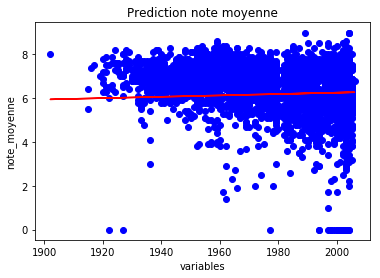

In [8]:
labSet3 = ls.LabeledSet(1)
labSet3.addExamples(d1[['release_date']].values ,d1[['vote_average']].values)
lset3, ltest3= ut.split(labSet3,0.6)


b1 = ClassifierGradiantBatch(1,1e-11)
nb= 50

pred = np.zeros(ltest3.size())

for i in range(0, nb):
    b1.train(lset3)

for i in range(0, ltest3.size()):
    pred[i]= b1.predict(ltest3.getX(i))
    
    
plt.scatter(ltest3.x,ltest3.y,  color='blue') 
plt.title('Prediction note moyenne') 
plt.xlabel('variables') 
plt.ylabel('note_moyenne') 
plt.plot(ltest3.x,pred,  color='red') 
plt.show()

In [53]:
films = pkl.load(open('data/film_v2.pkl', "rb"))
dfilms=pd.DataFrame(films)
dfilms= dfilms[:10000]

d1= dfilms[['popularity','release_date','vote_count','vote_average']]
d1= d1[d1['release_date'].str.len()==10] #filter ligne vide dans realease_date
d1['release_date']= d1['release_date'].apply(lambda l: float(l[0:4])) #on garde seulement l'année
d1= d1.fillna(d1.mean()) #on remplie les cellules nulles

labSet1 = ls.LabeledSet(3)
labSet1.addExamples(d1[['popularity','release_date','vote_count']].values ,d1[['vote_average']].values)
lset1, ltest1= ut.split(labSet1,0.6)

In [2]:
class ClassifierGradiantBatch(cl.Classifier):
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        v = np.random.rand(input_dimension)
        self.w = (2* v - 1) / np.linalg.norm(v)
        
    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        return np.dot(x, self.w)
    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        r = list(range(0,labeledSet.size(),1))
        random.shuffle(r)
        g = 0
        for i in range(labeledSet.size()):
            x = labeledSet.getX(r[i])
            g += (labeledSet.getY(r[i])-np.dot(self.w, x)) * x
        self.w += self.learning_rate * g
        return self.w
    
    def loss(self, dataset):
        l = 0
        for i in range(dataset.size()):
            l += (dataset.getY(i) - np.dot(self.w, dataset.getX(i)))**2
        return l / dataset.size()

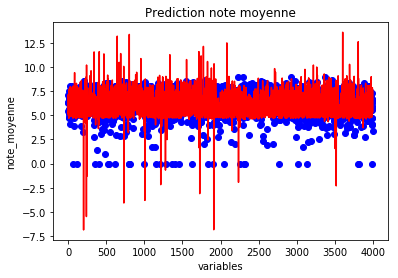

In [9]:
films = pkl.load(open('data/film_v2.pkl', "rb"))
dfilms=pd.DataFrame(films)
films= dfilms[:10000]

d1= films[['popularity','release_date','vote_count','vote_average']]
d1= d1[d1['release_date'].str.len()==10] #filter ligne vide dans realease_date
d1['release_date']= d1['release_date'].apply(lambda l: float(l[0:4])) #on garde seulement l'année
d1= d1.fillna(d1.mean()) #on remplie les cellules nulles

labSet1 = ls.LabeledSet(3)
labSet1.addExamples(d1[['popularity','release_date','vote_count']].values ,d1[['vote_average']].values)
lset1, ltest1= ut.split(labSet1,0.6)

b1 = ClassifierGradiantBatch(3,1e-11)
nb= 100

pred = np.zeros(ltest1.size())
y= np.zeros(ltest1.size())
x= np.zeros(ltest1.size())

for i in range(0, nb):
    b1.train(lset1)

for i in range(0, ltest1.size()):
    pred[i]= b1.predict(ltest1.getX(i))

    
plt.scatter(range(0, ltest1.size()),ltest1.y,  color='blue') 
plt.title('Prediction note moyenne')
plt.xlabel('variables') 
plt.ylabel('note_moyenne')
plt.plot(range(0, ltest1.size()),pred,  color='red')
plt.show()

PREDICTION D'UN FILM POUR ADULTE

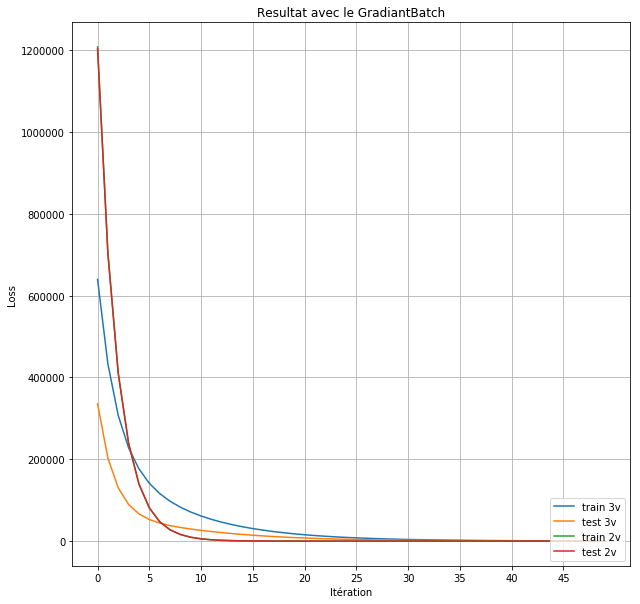

In [29]:
b1 = cl.ClassifierGradiantBatch(3,1e-11)
b2 = cl.ClassifierGradiantBatch(2,1e-11)
nb= 50

resloss1 = np.zeros(nb)
resloss1t = np.zeros(nb)
resloss2 = np.zeros(nb)
resloss2t = np.zeros(nb)

for i in range(0, nb):
    resloss1[i] = b1.loss(lset1)
    resloss1t[i] = b1.loss(ltest1)
    resloss2[i] = b2.loss(lset2)
    resloss2t[i] = b2.loss(ltest2)
    b1.train(lset1)
    b2.train(lset2)

fig,ax =plt.subplots(figsize=(10,10))
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(resloss1,label="train 3v")
ax.plot(resloss1t,label="test 3v")
ax.plot(resloss2,label="train 2v")
ax.plot(resloss2t,label="test 2v")
ax.legend(loc="lower right")
ax.set_xlabel("Itération")
ax.set_xticks(range(0,nb,int(nb/10)))
ax.set_ylabel("Loss")
ax.set_title("Resultat avec le GradiantBatch")
plt.show()

In [30]:
d2= films[['popularity','vote_count','vote_average','adult']]
d2['adult']= d2['adult'].apply(lambda l: 1 if l==True else -1 )
d2= d2.fillna(d2.mean())
adu = ls.LabeledSet(3)
adu.addExamples(d2[['popularity','vote_average','vote_count']].values , d2[['adult']].values)
atrain, atest= ut.split(adu,0.6)

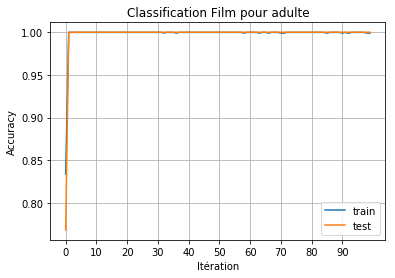

In [31]:
classpercptron = cl.ClassifierPerceptron(3,0.001)
nb=100
res1 = np.zeros(nb)
res2 = np.zeros(nb)


for i in range(0,nb):
    res1[i] = classpercptron.accuracy(atrain)
    res2[i] = classpercptron.accuracy(atest)
    classpercptron.train(atrain)
    
fig,ax =plt.subplots()
ax.grid(True)
ax.set_axisbelow(True)
ax.plot(res1,label="train")
ax.plot(res2,label="test")
ax.legend(loc="best")
ax.set_xlabel("Itération")
ax.set_xticks(range(0,nb,int(nb/10)))
ax.set_ylabel("Accuracy")
ax.set_title("Classification Film pour adulte")
plt.show()


Ici, nous nous intérrogeons aux effectifs par genre et selon les différentes sections.

In [21]:
d= data_crews[['department','gender']]
s = list(set(d['department']))
dico = dict()

for i in range(len(s)):
    dico[s[i]] = i
    
dicoi= dict()
for key, value in dico.items():
    dicoi[value]= key
    
d['department'] = d['department'].apply(lambda e : dico[e])
d['department'] = d['department'].astype(int)
d['gender']= d['gender'].apply(lambda l: 2 if l==0 else l)

In [27]:
#calcul effectif pour chaque departement par sexe
def plus(d,g,l):
    l[g-1][d]+=1
l= np.zeros((2,len(dico))) 
a= d.apply(lambda r: plus(r[0],r[1],l) ,axis=1) 

# arrange le tuple des noms pour l'abscisse
index = np.arange(len(dico)) 
tup= ()
for i in index:
    tup= tup + (dicoi[i],)

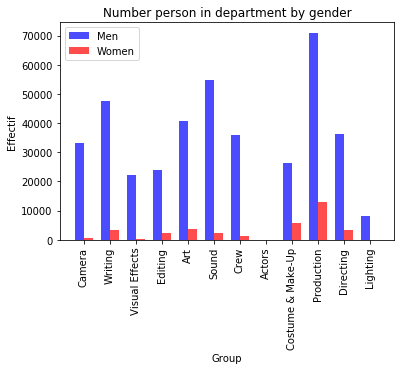

In [23]:
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 0.7
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, l[1], bar_width,
                alpha=opacity, color='b', error_kw=error_config,
                label='Men')

rects2 = ax.bar(index + bar_width, l[0], bar_width,
                alpha=opacity, color='r', error_kw=error_config,
                label='Women')

ax.set_xlabel('Group')
ax.set_ylabel('Effectif')

plt.xticks(rotation=90)
ax.set_title('Number person in department by gender')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(tup)
ax.legend()

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [26]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in acteurs:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
cpt = 0
for i in range(len(acteurs)):
    for j in range(len(acteurs[i])):
        if acteurs[i][j]['name'] == 'Tom Hanks':
            cpt += 1
print(cpt)
# Dans combien de comédies...

# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches

57
